# Time stamp based video labeling from single camera

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\INCUBAÇÃO\Cameras


### Load videos control dataset

In [55]:
import numpy as np, pandas as pd

# load data

video_control_path = 'Dados/Controle de vídeos/videos_control_19-04.csv'
control = pd.read_csv(video_control_path)

# data preprocessing
control['timestamp'] = pd.to_datetime(control['timestamp'])
control = control.set_index('timestamp', drop=True).sort_index()

## Define video timestamp labels and parameters

In [65]:
# set parameters

start = '2023-02-07'
end = '2023-03-02'

query = {
    'code': [1475],
    'folder_structure': [
        'polygons/{type}/{polygon}/{code}',
        '{source}/{type}/{event}/{code}',
    ]
}

time_label = {
    '2023-02-07 19:25:00': 'alagamento', # start 07/02
    '2023-02-08 00:35:00': 'bolsão', # start 08/02
    '2023-02-08 01:15:00': 'lâmina',
    '2023-02-08 01:52:30': 'poça',
    '2023-02-08 02:32:30': 'normalidade',
    '2023-02-11 20:50:00': 'alagamento', # start 11/02
    '2023-02-11 20:51:00': 'normalidade', # end 11/02
    '2023-03-02 00:00:00': 'normalidade', # after end of 2023-03-01 ?
}

##  Time stamp based video labeling from single camera

In [66]:
# take video dataset

df = control.copy()

# query video dataset

for key in query:
    df = df[df[key].isin(query[key])]

# cut video dataset

df = df[(df.index >= start) & (df.index <= end)]

# label videos by timestamps' categories

time_label = pd.Series(time_label).sort_index()

n_labels = len(time_label)
stamps = time_label.index

labels = pd.Series(np.nan, df.index)

for i in range(n_labels - 1):
    t1, t2 = stamps[i], stamps[i + 1]
    msk_t = (df.index >= t1) & (df.index <= t2)
    labels[msk_t] = time_label.loc[t1]

df['tag'] = labels

# display result label count

display(df.head()[['blob_name', 'code', 'tag']])
display(df['tag'].value_counts().to_frame('Video tag count'))

,blob_name,code,tag
timestamp,,,
2023-02-07 19:25:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,1475,alagamento
2023-02-07 19:30:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,1475,alagamento
2023-02-07 19:35:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,1475,alagamento
2023-02-07 19:40:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,1475,alagamento
2023-02-07 19:50:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,1475,alagamento


,Video tag count
tag,
normalidade,120
alagamento,28
poça,8
lâmina,6
bolsão,3


### Check result's unique dates

In [67]:
print(np.unique(df.index.date))

[datetime.date(2023, 2, 7) datetime.date(2023, 2, 8)
 datetime.date(2023, 2, 11) datetime.date(2023, 2, 28)
 datetime.date(2023, 3, 1)]


### Save labeled dataset as csv

In [68]:
labeled_videos_path = 'Dados/Rotulos/1475_2023-02-07.csv'

df.reset_index().to_csv(labeled_videos_path, index=False)

---
## Exploratory data analysis 

In [3]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\INCUBAÇÃO\Cameras


In [1]:
import numpy as np, pandas as pd

c:\Users\luisr\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Reload labeled videos dataset

In [4]:
videos = pd.read_csv('Dados/Rotulos/1475_2023-02-07.csv')

videos['timestamp'] = pd.to_datetime(videos['timestamp'])
videos = videos.set_index('timestamp', drop=True).sort_index()

videos.head()

,blob_name,blob_size,bucket_name,file_name,code,n_folders,folder_structure,tag
timestamp,,,,,,,,
2023-02-07 19:25:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,206926,flood-video-collection,CODE1475 2023-02-07 19:25:00.mp4,1475,5,polygons/{type}/{polygon}/{code},alagamento
2023-02-07 19:30:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,261337,flood-video-collection,CODE1475 2023-02-07 19:30:00.mp4,1475,5,polygons/{type}/{polygon}/{code},alagamento
2023-02-07 19:35:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,234652,flood-video-collection,CODE1475 2023-02-07 19:35:00.mp4,1475,5,polygons/{type}/{polygon}/{code},alagamento
2023-02-07 19:40:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,287397,flood-video-collection,CODE1475 2023-02-07 19:40:00.mp4,1475,5,polygons/{type}/{polygon}/{code},alagamento
2023-02-07 19:50:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,211736,flood-video-collection,CODE1475 2023-02-07 19:50:00.mp4,1475,5,polygons/{type}/{polygon}/{code},alagamento


#### Bytes of largest videos

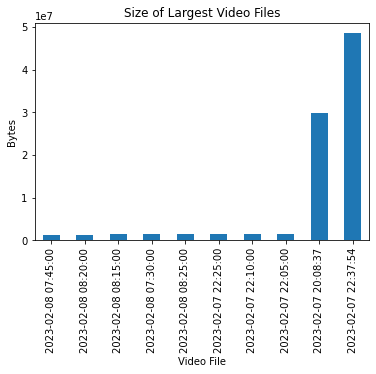

In [6]:
ax = videos['blob_size'].sort_values(ascending=True).tail(10).plot.bar(
    ylabel='Bytes', xlabel='Video File', title='Size of Largest Video Files'
)